In [29]:
import json, glob, os, io
import pandas as pd
from datetime import time, timedelta, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import islice
import matplotlib.animation as animation
# from IPython.display import HTML
import matplotlib.style as style
import pickle
import numpy as np
style.available
style.use('fivethirtyeight')

# returns a list of all paths to files that are of interest
def get_json_paths(path="./"):
    return glob.glob("{}**/message_1.json".format(path),recursive=True)

# finds the facebook name by scrapping the file
def get_username(paths):
    possible_usernames=[]
    username=""
    for path in paths:
        if username:
            break
        with io.open(path, mode="r", encoding="utf-8") as f:
            raw = json.load(f)
        contacts = raw["participants"]
        if len(contacts) > 2:
            continue
        for contact in contacts:
            if contact["name"] in possible_usernames:
                username=contact["name"]
                break
            else:
                possible_usernames.append(contact["name"])
    return username
        
            

# returns the number of messages to every contact between 2 timestamps in a discussion
def data_from_messages_json( since, to, name, path):
#     messages = pd.read_json(path)["messages"]
    with io.open(path, mode="r", encoding="utf-8") as f:
        raw = json.load(f)
    messages = raw["messages"]
    temp_messages = []
    for message in messages:
#         print("{} > {} and {} < {} donc : {}".format(message["timestamp_ms"],since,message["timestamp_ms"],to,message["timestamp_ms"] > since and message["timestamp_ms"]<to))
        if message["timestamp_ms"] > since and message["timestamp_ms"]<to:
            temp_messages.append(message)
    messages=temp_messages
    
    participants = []
    for d in raw["participants"]:
        if d["name"]!=name:
            participants.append(d["name"])
    
    #il se passe un truc chelou la dessous ça parait pas ultra opti
    d = {}
    for k in ['sender_name', 'timestamp_ms']:
      d[k] = list(d[k] for d in messages)
    return (participants, d["sender_name"].count(name))

# returns a list of every contact in your data
def all_participants(dict_nb_message_per_week):
    res = []
    for week in dict_nb_message_per_week.values():
        for participant in week.keys():
            if participant not in res:
                res.append(participant)
    return res

# returns a dict with a rgb tuple for every contact
def get_bars_color(contacts):
    np.random.seed(420) # seed to be consistent
    return {k:v for k,v in zip(contacts, np.random.rand(len(contacts),3))}
        
# returns a dictionary with the 10 most talked to contacts between 2 timestamps
def nb_message(since, to, name, paths, dir_path="./"):
    res={}
    for path in paths:
        (participants, nb) = data_from_messages_json( since, to, name, path) 
        for participant in participants:
            try:
                res[participant]=res[participant]+nb
            except:
                res[participant]=nb
    return {k: v for k, v in res.items() if v > 10}

def draw_barchart(week, nb_msg_per_week, colors):
    nb_msg_per_contact = nb_msg_per_week[week]
    ax.clear()
    contacts=list(nb_msg_per_contact.keys())
    ax.barh(contacts, list(nb_msg_per_contact.values()), color=[colors[x] for x in contacts])
    dx = max(list(nb_msg_per_contact.values())) / 200 if nb_msg_per_contact else 0
    
    for i, (value, name) in enumerate(zip(list(nb_msg_per_contact.values()), list(nb_msg_per_contact.keys()))):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
                       
    date = datetime.fromtimestamp(round(week)).strftime("%d-%m-%Y")
    print("drawing week {}".format(date))
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    
def list_weeks_since(nb_weeks):
    return [datetime.now()+timedelta(weeks=-nb_week) for nb_week in range(nb_weeks)]

def list_days_since(nb_weeks):
    return [datetime.now()+timedelta(days=-nb_days) for nb_days in range(nb_weeks*7)]
        
# returns a list of every week since nb week with the top 10 most talked to contacts and the number of messages to each one of them    
def dict_nb_msg_per_week(nb_weeks):
    paths = get_json_paths()
    name = get_username(paths)
    res = {}
    for week in list_weeks_since(nb_weeks):
        this_week = {k: v for k, v in sorted(nb_message(datetime.timestamp(week+timedelta(weeks=-4))*1000,
                                                        datetime.timestamp(week)*1000,
                                                        name,
                                                        paths).items(),
                                             key=lambda item: item[1])}
        week_top = {}
        for sender in list(this_week)[-10:]:
            week_top.update({sender:this_week[sender]})
        res.update({datetime.timestamp(week):week_top})
    return res

# returns a list of every day since nb week with the top 10 most talked to contacts and the number of messages to each one of them    
def dict_nb_msg_per_day(nb_weeks):
    paths = get_json_paths()
    name = get_username(paths)
    print("analisis of {}'s messages".format(name))
    res = {}
    for day in list_days_since(nb_weeks):
        this_day = {k: v for k, v in sorted(nb_message(datetime.timestamp(day+timedelta(weeks=-4))*1000,
                                                        datetime.timestamp(day)*1000,
                                                        name,
                                                        paths).items(),
                                             key=lambda item: item[1])}
        day_top = {}
        for sender in list(this_day)[-10:]:
            day_top.update({sender:this_day[sender]})
        res.update({datetime.timestamp(day):day_top})
    return res

## visualisation but it's not working in a function, only in a cell it's strange

def friendviz(nb_weeks, name):
    #nb_msg_week = {timestamp:[top10]}
#     nb_msg_week=dict_nb_msg_per_week(nb_weeks)
#     fig, ax = plt.subplots(figsize=(15, 15))
#     animator= animation.FuncAnimation(fig, draw_barchart, frames=list(nb_msg_week.keys()), fargs=(nb_msg_week,))
#     animator.save('friends2.gif', fps=1, dpi=200)
    nb_msg_week = dict_nb_msg_per_week(nb_weeks, name)
    frames=list(nb_msg_week.keys())
    frames.reverse() # pour l'ordre d'apparition des slides
    fig, ax = plt.subplots(figsize=(15, 12))
    animator= animation.FuncAnimation(fig,draw_barchart, frames=frames,fargs=(nb_msg_week,))
    animator.save('friends_monthly_{}w.gif'.format(nb_weeks), fps=1, dpi=300),

## Data
If you tinker with your data it might be helpful to serialize it

In [19]:
get_username(get_json_paths())

'Louis Lenoir'

In [3]:
name = "Louis Lenoir"
to_pickle = dict_nb_msg_per_daily(52*6, name)
print(to_pickle)
filename = 'friends_daily_6y.pickle'
outfile = open(filename,'wb')
pickle.dump(to_pickle,outfile)
outfile.close()

{1585513206.532032: {'Mathilde Boucard': 44, 'Eva Lorton': 47, 'Louis Cnt': 49, 'Hiba El Mouhib': 49, 'Naya Castagnos': 50, 'Sofiane Abadou': 80, 'Thomas Riou': 88, 'Louis Lenoir': 88, 'Mathias Van Audenhove': 340, 'Remy Fneich': 719}, 1584912006.532072: {'Marie Vacoret': 51, 'Eva Lorton': 53, 'Louis Cnt': 57, 'AdÃ¨le Juliard': 59, 'Mathilde Boucard': 60, 'Thomas Riou': 73, 'Sofiane Abadou': 81, 'Louis Lenoir': 86, 'Mathias Van Audenhove': 351, 'Remy Fneich': 633}, 1584307206.532083: {'Marie Vacoret': 36, 'Gabriel Feltgen': 42, 'Louis Cnt': 44, 'Mathilde Boucard': 52, 'AdÃ¨le Juliard': 53, 'Sofiane Abadou': 67, 'Thomas Riou': 69, 'Louis Lenoir': 69, 'Mathias Van Audenhove': 351, 'Remy Fneich': 372}, 1583702406.532094: {'Louis Germain': 47, 'Louis Cuvilliez': 51, 'Maxime Soenen': 51, 'Achraf Talby': 59, 'Gabriel Feltgen': 65, 'Sofiane Abadou': 82, 'Amin Zeghib': 84, 'Louis Lenoir': 105, 'Remy Fneich': 331, 'Mathias Van Audenhove': 343}, 1583097606.532103: {'Mathilde Boucard': 46, 'Achra

In [2]:
infile = open('friends_monthly_6y.pickle','rb')
monthly_6y = pickle.load(infile)
infile.close()
# print(monthly_6y)

## Bar chart race

analisis of Louis Lenoir's messages'
drawing week 07-02-2020
drawing week 07-02-2020
drawing week 08-02-2020
drawing week 09-02-2020
drawing week 10-02-2020
drawing week 11-02-2020
drawing week 12-02-2020
drawing week 13-02-2020
drawing week 14-02-2020
drawing week 15-02-2020
drawing week 16-02-2020
drawing week 17-02-2020
drawing week 18-02-2020
drawing week 19-02-2020
drawing week 20-02-2020
drawing week 21-02-2020
drawing week 22-02-2020
drawing week 23-02-2020
drawing week 24-02-2020
drawing week 25-02-2020
drawing week 26-02-2020
drawing week 27-02-2020
drawing week 28-02-2020
drawing week 29-02-2020
drawing week 01-03-2020
drawing week 02-03-2020
drawing week 03-03-2020
drawing week 04-03-2020
drawing week 05-03-2020
drawing week 06-03-2020
drawing week 07-03-2020
drawing week 08-03-2020
drawing week 09-03-2020
drawing week 10-03-2020
drawing week 11-03-2020
drawing week 12-03-2020
drawing week 13-03-2020
drawing week 14-03-2020
drawing week 15-03-2020
drawing week 16-03-2020
dra

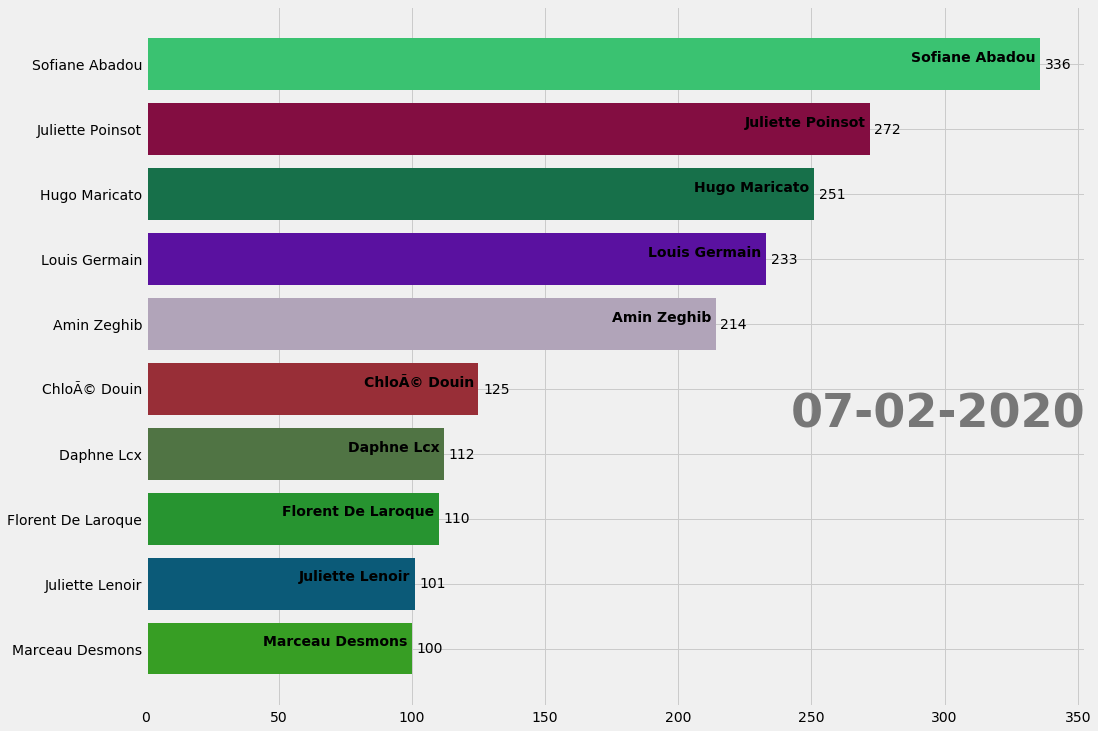

In [28]:
# replace 52*6 by how much time you want
nb_msg_week = dict_nb_msg_per_day(10)
# type the name of your output file
out_name="friendviz_6y_daily_Louis.mp4"

colors = get_bars_color(all_participants(nb_msg_week))

frames=list(nb_msg_week.keys())
frames.reverse() # pour l'ordre d'apparition des slides

fig, ax = plt.subplots(figsize=(15, 12))
animator= animation.FuncAnimation(fig,draw_barchart, frames=frames,fargs=(nb_msg_week,colors,))

# besoin d'avoir ffmpeg installé
Writer = animation.writers['ffmpeg']
writer = Writer(fps=7, metadata=dict(artist='Louis Lenoir'), bitrate=1800)
animator.save(out_name, writer=writer)